In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, '/scratch/fivanovic/Work/X-SH/eigenstate_plotting')
import XSH_eigenstates_Filip as XSF

sys.path.insert(0, '/scratch/fivanovic/X-SH/T6-PDI/production_runs/analysis_scripts')
import file_parsers as FP
import xsh_analysis_functions as XSA

In [2]:
e10_offset0p4_gs_info = np.loadtxt('/scratch/fivanovic/X-SH/T6-PDI/production_runs/physical_system_optical/energy_landscape/e10_offset0.4_gs_array.txt')
e3p5_offset0p4_gs_info = np.loadtxt('/scratch/fivanovic/X-SH/T6-PDI/production_runs/physical_system_optical/energy_landscape/e3p5_offset0.4_gs_array.txt')

e10_lowestCT_info = np.loadtxt('/scratch/fivanovic/X-SH/T6-PDI/production_runs/physical_system_optical/energy_landscape/e10_CT_adiabat_array.txt')
e3p5_lowestCT_info = np.loadtxt('/scratch/fivanovic/X-SH/T6-PDI/production_runs/physical_system_optical/energy_landscape/e3p5_CT_adiabat_array.txt')

FileNotFoundError: /scratch/fivanovic/X-SH/T6-PDI/production_runs/physical_system_optical/energy_landscape/e10_offset0.4_gs_array.txt not found.

In [3]:
energy_differences = e10_offset0p4_gs_info[:,3] - e3p5_offset0p4_gs_info[:,3]
pXT_differences = e10_offset0p4_gs_info[:,0] - e3p5_offset0p4_gs_info[:,0]
p_iCT_differences = e10_offset0p4_gs_info[:,1] - e3p5_offset0p4_gs_info[:,1]

e3p5_excitonic_indices = np.where(e3p5_offset0p4_gs_info[:,0] > 0.9)[0]
e3p5_CT_indices = np.where(e3p5_offset0p4_gs_info[:,0] < 0.1)[0]

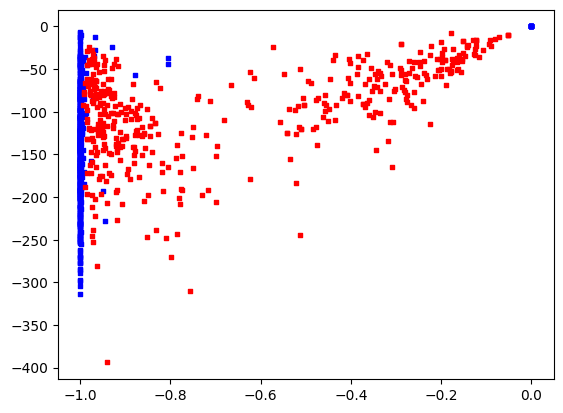

In [4]:
plt.scatter(pXT_differences[e3p5_excitonic_indices], energy_differences[e3p5_excitonic_indices], s = 5, marker = 's', color = 'b')
plt.scatter(p_iCT_differences[e3p5_CT_indices], energy_differences[e3p5_CT_indices], s = 5, marker = 's', color = 'r')

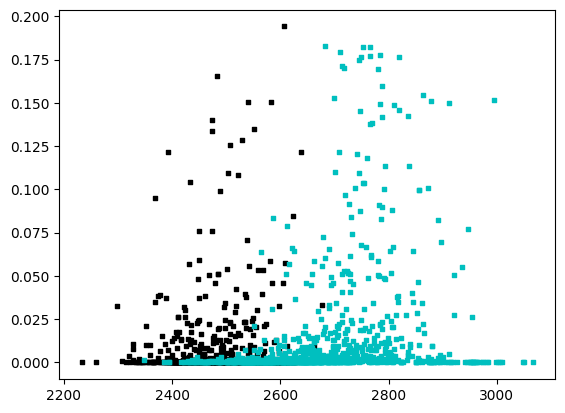

In [6]:
plt.scatter(e10_lowestCT_info[:,2]*27211, e10_lowestCT_info[:,0], color = 'k', marker = 's', s = 5)
plt.scatter(e3p5_lowestCT_info[:,2]*27211, e3p5_lowestCT_info[:,0], color = 'c', marker = 's', s = 5)

In [34]:
vecs = XSF.build_lattice(40,1,5)
dons, accs = XSF.DA_index(vecs, 20)
nearest_neighbours = XSF.build_connectivity(vecs, 5)

CT_states = XSF.define_CT_states(dons, accs)
XT_states = XSF.define_XT_states(accs)

decomp_pseudoH = FP.xyz_parser('pseudoH_e5_decomp.xyz', 3)

decomp_pseudoH = XSA.build_sim_H(decomp_pseudoH, 420)
decomp_pseudoH = decomp_pseudoH*27211

decomp_H_diagonals = np.diag(decomp_pseudoH)

x_distances, y_distances = XSF.get_CT_distances(CT_states, vecs)
coulomb_barrier = [((-576/d - 1e-3*1000*5*d) - (-576 - 1e-3*1000*5)) for d in np.array(x_distances)/5]

near_zero_indices = np.where(abs(decomp_pseudoH) < 10)
decomp_pseudoH[near_zero_indices[0], near_zero_indices[1]] = 0

for index in range(len(decomp_pseudoH[:400])):
    decomp_pseudoH[index,index] = decomp_pseudoH[index,index] - decomp_H_diagonals[index] + coulomb_barrier[index]

for index in range(len(decomp_pseudoH[400:])):
    decomp_pseudoH[400+index, 400+index] = decomp_pseudoH[400+index, 400+index] - decomp_H_diagonals[400+index] + 400

decomp_eigenvals, decomp_eigenvecs = XSF.get_eigen(decomp_pseudoH)

binned_d_eigenvals, binned_d_eigenvecs, used_energy_bins = XSF.bin_eigenspectrum(decomp_eigenvals, decomp_eigenvecs, 25)

In [35]:
def average_binned_populations(binned_eigenvecs, donor_list, acceptor_list, exciton_states, y_molecules):
    '''
    function that will take the binned matrices of eigenvectors, calculate the XT and CT populations of each
    eigenvector, then average the populations for each bin of eigenvectors
    '''

    number_bins = len(binned_eigenvecs)
    x_donors = len(donor_list)//y_molecules
    x_acceptors = len(acceptor_list)//y_molecules
    x_excitons = len(exciton_states)//y_molecules

    donor_avg_population_array = np.zeros((number_bins, x_donors))
    acceptor_avg_population_array = np.zeros((number_bins, x_acceptors))
    exciton_avg_population_array = np.zeros((number_bins, x_excitons))

    for index in range(len(binned_eigenvecs)):

        matrix_transpose = binned_eigenvecs[index].T

        donor_population_array = np.zeros((len(matrix_transpose), x_donors))
        acceptor_population_array = np.zeros((len(matrix_transpose), x_acceptors))
        exciton_population_array = np.zeros((len(matrix_transpose), x_excitons))

        for index2 in range(len(matrix_transpose)):

            donor_populations, acceptor_populations = XSF.CT_site_populations(matrix_transpose[index2], donor_list, acceptor_list)
            exciton_populations = XSF.XT_site_populations(matrix_transpose[index2], exciton_states)

            integrated_donors, integrated_acceptors = XSF.integrated_CT_populations(donor_populations, acceptor_populations, y_molecules)
            integrated_excitons = XSF.integrated_XT_populations(exciton_populations, y_molecules)

            donor_population_array[index2,:] = integrated_donors
            acceptor_population_array[index2,:] = integrated_acceptors
            exciton_population_array[index2,:] = integrated_excitons
        
        donor_population_average = np.mean(donor_population_array, axis=0)
        acceptor_population_average = np.mean(acceptor_population_array, axis=0)
        exciton_population_average = np.mean(exciton_population_array, axis=0)

        donor_avg_population_array[index,:] = donor_population_average
        acceptor_avg_population_array[index,:] = acceptor_population_average
        exciton_avg_population_array[index,:] = exciton_population_average

    return donor_avg_population_array, acceptor_avg_population_array, exciton_avg_population_array

Text(0.02, 0.5, 'Binned eigenstate energy /meV')

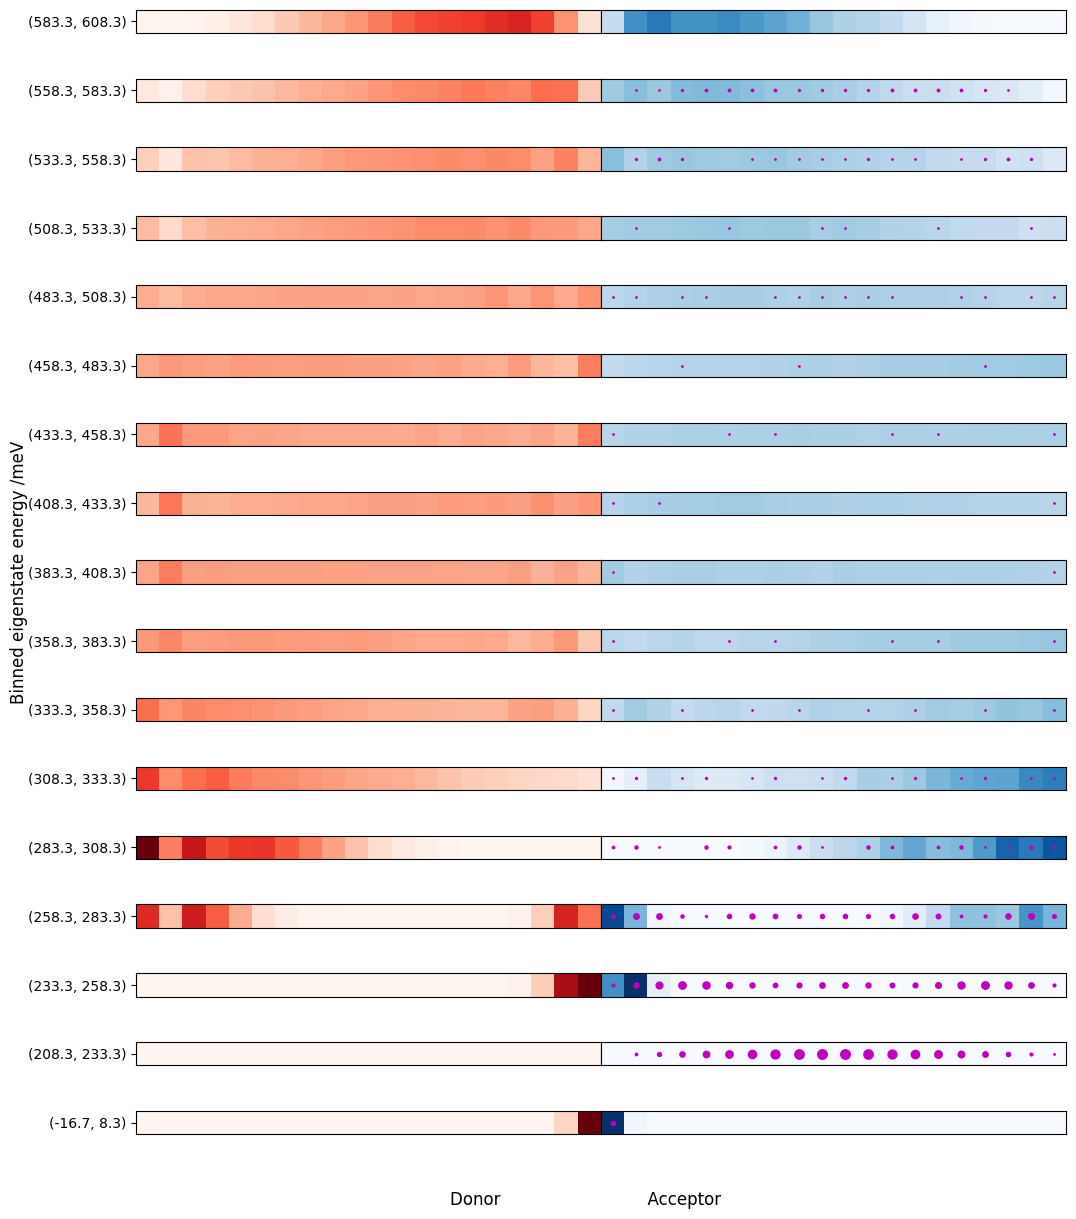

In [36]:
average_dpops, average_apops, average_exc_pops = average_binned_populations(binned_d_eigenvecs, dons, accs, XT_states, 1)
fig, axes = XSF.plot_eigenspectrum(average_dpops, average_apops, average_exc_pops, figure_size=(12,13), max_shading=0.15, exciton_radius=500, bins=used_energy_bins)
plt.subplots_adjust(wspace = 0, hspace = 0, bottom=0.05, top=0.95)
fig.supylabel('Binned eigenstate energy /meV')